# Simulations

This section simulates business cycles in the calibrated model by using aggregate demand shocks. We then calculate optimal government spending in response to the aggregate demand shocks. 

The simulations are based on Section 5 in Michaillat and Saez ([2019](https://www.pascalmichaillat.org/6.html))

In [1]:
# %load setup.py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mtick
from itertools import product

## Calibration

We first run `calibration.ipynb` to attain parameters needed for the sufficient statistics formula. All calibrated values based on US data between 2001-01-01 and 2019-12-31:

In [2]:
%%capture
%run calibration-suffstat.ipynb

We now run the additional calibration as follows:

In [3]:
%run calibration-sim.ipynb

## Simulations of Business Cycles
We first simulate business cycle simulations using aggregate demand shocks, fixing the public expenditure policy at $G/Y = 16.5\%$. For each magnitude of aggregate demand, we find the equilibrium labor market tightness using grid search. 

In [4]:
# Range of aggregate demand
ALPHA = np.arange(start=0.97, step=0.005, stop=1.03) 
# Grid to search for equilibrium tightness x
x0 = np.arange(start=0.001, step=0.001, stop=2) 
xad, Gad = np.empty(len(ALPHA)), np.empty(len(ALPHA))
G0 = GY_bar*Y(x0)	# G such that G/Y=16.5%
for i, alpha in enumerate(ALPHA):
    eva = findeq(G0, x0, alpha)
    # Finding where AS = AD
    ind = np.argmin(eva)
    # Record equlibrium tightness and public expenditure
    xad[i] = x0[ind]
    Gad[i] = G0[ind]

We then compute all other equilibrium variables with $G/Y = 16.5\%$ under the aggregate demand shocks. 

In [5]:
ad = pd.DataFrame({'Y': Y(xad),'u': u(xad), 'M':M(Gad, xad), 'G/Y':Gad/Y(xad)},index=ALPHA)

Let's first look at equilibria under aggregate demand shocks:

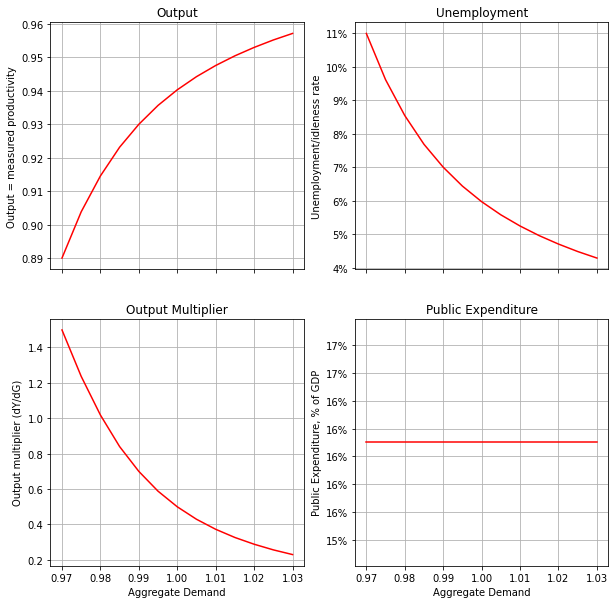

In [6]:
ad_axes = ad.plot(subplots=True, layout=(2, 2), title=['Output', 'Unemployment', 'Output Multiplier', 'Public Expenditure'], 
                legend=False, figsize=(10, 10), grid=True, color='red')
ad_axes[0, 0].set(xlabel=r'$\alpha$', ylabel='Output = measured productivity')
ad_axes[0, 1].set(xlabel=r'$\alpha$', ylabel='Unemployment/idleness rate')
ad_axes[0, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ad_axes[1, 0].set(xlabel='Aggregate Demand', ylabel='Output multiplier (dY/dG)')
ad_axes[1, 1].set(xlabel='Aggregate Demand', ylabel='Public Expenditure, % of GDP')
ad_axes[1, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

## Optimal Stimulus

In this section, we calculate optimal stimulus over the business cycle. We compute optimal stimulus in two ways. First, we find exact optimal stimulus using a grid search. We then calculate optimal stimulus using the sufficient-statistics formula. We then compare the two as a validity check for the sufficient-statistics approach.

### Exact Optimal Stimulus

We first calculate the exact optimal stimulus. We make use of the property where optimal public expenditure satisfy the Samuelson rule pluse an correction term:

                $1 = MRS_{gc} + \frac{\delta y}{\delta x}\frac{d x}{\delta g}.$          [![Generic badge](https://img.shields.io/badge/MS19-Eq%2018-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  




In [7]:
optimal = lambda G, x:abs(1 - MRS(G/(Y(x) - G)) - dlnydlnx(x)*dlnxdlng(G, x)*Y(x)/G)

In [8]:
xoptimal, Goptimal = np.empty(len(ALPHA)), np.empty(len(ALPHA))
# We now use grid search over a 2-d grid to find eq G and x
GY0 = np.arange(start=0.07, step=0.0005, stop=0.25) 
x1, GY1 = np.meshgrid(x0, GY0)
G1 = GY1*Y(x1)
for i, alpha in enumerate(ALPHA):
    eva = findeq(G1, x1, alpha)
    # Finding where AS = AD
    ind = np.argmin(eva, axis=1)
    x2 = x0[ind]
    G2 = GY0*Y(x2)
    eva = optimal(G2, x2)
    # Finding where AS = AD
    ind = np.argmin(eva)
    # Record equlibrium tightness and public expenditure
    xoptimal[i] = x2[ind]
    Goptimal[i] = G2[ind]

We can now calculate other macroeconomic variables. 

In [9]:
exact_opt = pd.DataFrame({'Y': Y(xoptimal),'u': u(xoptimal), 'M':M(Goptimal, xoptimal), 'G/Y':Goptimal/Y(xoptimal)}, index=ALPHA)

We can see how these variables compare to when $G/Y = 16.5\%$: 

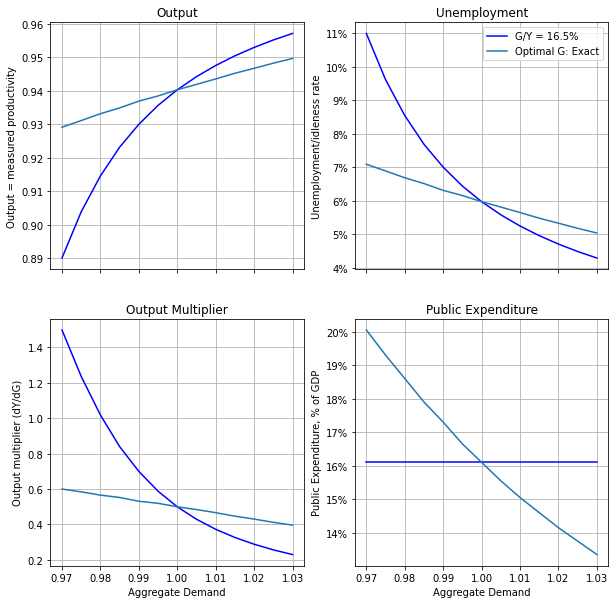

In [10]:
ad_axes = ad.plot(subplots=True, layout=(2, 2), title=['Output', 'Unemployment', 'Output Multiplier', 'Public Expenditure'], 
                  legend=False, figsize=(10, 10), grid=True, color='blue', label='G/Y = 15%')
exact_opt['Y'].plot(ax=ad_axes[0, 0], grid=True)
exact_opt['u'].plot(ax=ad_axes[0, 1], grid=True)
exact_opt['M'].plot(ax=ad_axes[1, 0], grid=True)
exact_opt['G/Y'].plot(ax=ad_axes[1, 1], grid=True)
ad_axes[0, 0].set(ylabel='Output = measured productivity')
ad_axes[0, 1].set(ylabel='Unemployment/idleness rate')
ad_axes[0, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ad_axes[1, 0].set(xlabel='Aggregate Demand', ylabel='Output multiplier (dY/dG)')
ad_axes[1, 1].set(xlabel='Aggregate Demand', ylabel='Public Expenditure, % of GDP')
ad_axes[0, 1].legend(['G/Y = 16.5%', 'Optimal G: Exact'])
ad_axes[1, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

### The Sufficient-Statistics Approach

Recall 

                $\frac{g/c - (g/c)^*}{(g/c)^*} \approx \frac{z_0 \epsilon m}{1 + z_1 z_0\epsilon m^2}\cdot \frac{u_0 - \bar{u}}{\bar{u}}.$          [![Generic badge](https://img.shields.io/badge/MS19-Eq%2023-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  
                
We can use this formula to calculate optimal stimulus in response to the shocks above.

In [11]:
suffstat = lambda G, x:epsilon*z0*m(G,x)/(1 + z1*z0*epsilon*m(G,x)**2)

We then compute optimal stimulus in response to aggregate demand shocks:

In [12]:
xsuffstat, Gsuffstat = np.empty(len(ALPHA)), np.empty(len(ALPHA))
for i, alpha in enumerate(ALPHA):
    du = (u(xad[i])-u_bar)/u_bar
    suffstat0 = suffstat(Gad[i], xad[i])*du
    G0 = GY((1 + suffstat0)*GC_bar)*Y(x0)
    eva = findeq(G0, x0, alpha)
    # Finding where AS = AD
    ind = np.argmin(eva)
    # Record equlibrium tightness and public expenditure
    xsuffstat[i] = x0[ind]
    Gsuffstat[i] = G0[ind]

We compute the other macroeconomics variables and compare them with when $G/Y$ is fixed at $16.5\%$

In [13]:
ss = pd.DataFrame({'Y': Y(xsuffstat),'u': u(xsuffstat), 'M':M(Gsuffstat, xsuffstat), 'G/Y':Gsuffstat/Y(xsuffstat)},index=ALPHA)

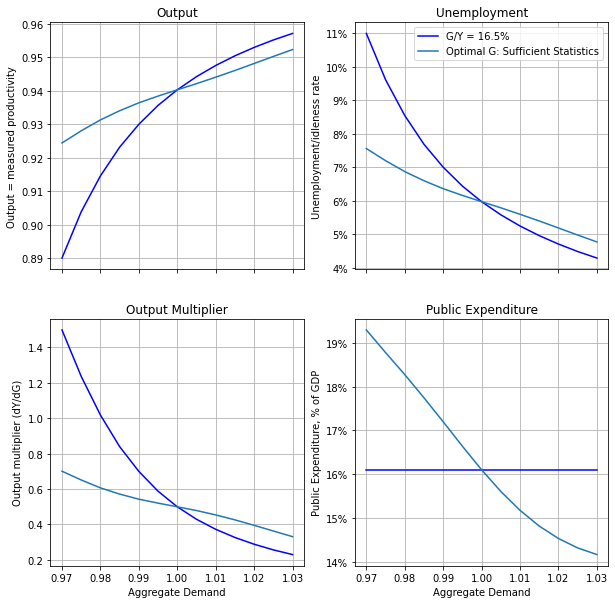

In [14]:
ad_axes = ad.plot(subplots=True, layout=(2, 2), title=['Output', 'Unemployment', 'Output Multiplier', 'Public Expenditure'], 
                legend=False, figsize=(10, 10), grid=True, color='blue', label='G/Y = 15%')
ss['Y'].plot(ax=ad_axes[0, 0], grid=True)
ss['u'].plot(ax=ad_axes[0, 1], grid=True)
ss['M'].plot(ax=ad_axes[1, 0], grid=True)
ss['G/Y'].plot(ax=ad_axes[1, 1], grid=True)
ad_axes[0, 0].set(ylabel='Output = measured productivity')
ad_axes[0, 1].set(ylabel='Unemployment/idleness rate')
ad_axes[0, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ad_axes[1, 0].set(xlabel='Aggregate Demand', ylabel='Output multiplier (dY/dG)')
ad_axes[1, 1].set(xlabel='Aggregate Demand', ylabel='Public Expenditure, % of GDP')
ad_axes[0, 1].legend(['G/Y = 16.5%', 'Optimal G: Sufficient Statistics'])
ad_axes[1, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

We can also compare the exact solution with the solution given by the sufficient-statistics formula:

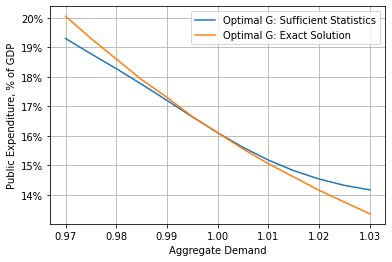

In [15]:
ss_ax = ss['G/Y'].plot(label='Optimal G: Sufficient Statistics', grid=True)
ss_ax.set(xlabel='Aggregate Demand', ylabel='Public Expenditure, % of GDP')
ss_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
exact_opt['G/Y'].plot(ax=ss_ax, grid=True, label='Optimal G: Exact Solution')
ss_ax.legend()